### 🔧Model Training

In [43]:
# Clean feature matrix and target
X = df.drop(columns=[
    'TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId',
    'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory',
    'ChannelId', 'TransactionStartTime', 'PricingStrategy', 'FraudResult', 'is_high_risk'
])
y = df['is_high_risk']

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Train models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"✅ {name} trained.")


✅ Logistic Regression trained.
✅ Random Forest trained.


c:\Users\HP\OneDrive\Desktop\Tenx\bati_credit_risk_model\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:36:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost trained.


### 📊 Model Evaluation

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

for name, model in models.items():
    print(f"\n🔍 Evaluation for: {name}")
    y_pred = model.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))



🔍 Evaluation for: Logistic Regression
Confusion Matrix:
[[18297    18]
 [  160   658]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9913    0.9990    0.9952     18315
           1     0.9734    0.8044    0.8809       818

    accuracy                         0.9907     19133
   macro avg     0.9824    0.9017    0.9380     19133
weighted avg     0.9906    0.9907    0.9903     19133


🔍 Evaluation for: Random Forest
Confusion Matrix:
[[18285    30]
 [   33   785]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9982    0.9984    0.9983     18315
           1     0.9632    0.9597    0.9614       818

    accuracy                         0.9967     19133
   macro avg     0.9807    0.9790    0.9799     19133
weighted avg     0.9967    0.9967    0.9967     19133


🔍 Evaluation for: XGBoost
Confusion Matrix:
[[18273    42]
 [   33   785]]

Classification Report:
              precision    r

## Evaluation Summary

### Logistic Regression

| Metric       | Class 0 (Low Risk) | Class 1 (High Risk) |
| ------------ | ------------------ | ------------------- |
| Precision    | 99.13%             | 97.34%              |
| Recall       | 99.90%             | **80.44%**          |
| F1-Score     | 99.52%             | 88.09%              |
| **Accuracy** | 99.07%             |                     |

### Random Forest

| Metric       | Class 0 (Low Risk) | Class 1 (High Risk) |
| ------------ | ------------------ | ------------------- |
| Precision    | \[not shown]       | Very High           |
| Recall       | \[not shown]       | **\~96%** (785/818) |
| F1-Score     | \[not shown]       | Likely **> 94%**    |
| **Accuracy** | **99.61%**         |                     |
| Support      | 18315 / 818        |                     |


### 🏆Model Selection

> We selected **Random Forest** because it showed the highest F1-score and/or recall for predicting high-risk customers (`is_high_risk = 1`).


### 💾Save the Best Model

In [45]:
import os
import joblib

os.makedirs("../models", exist_ok=True)  # Creates the folder if it doesn't exist
joblib.dump(models["XGBoost"], "../models/best_model.pkl")  # or "Random Forest"
print("✅ Best model saved.")


✅ Best model saved.


### 🧪Model Loading Test

In [46]:
# Reload and test
loaded_model = joblib.load("../models/best_model.pkl")
y_pred = loaded_model.predict(X_test)
print("✅ Loaded model prediction complete.")


✅ Loaded model prediction complete.


### ROC Curve

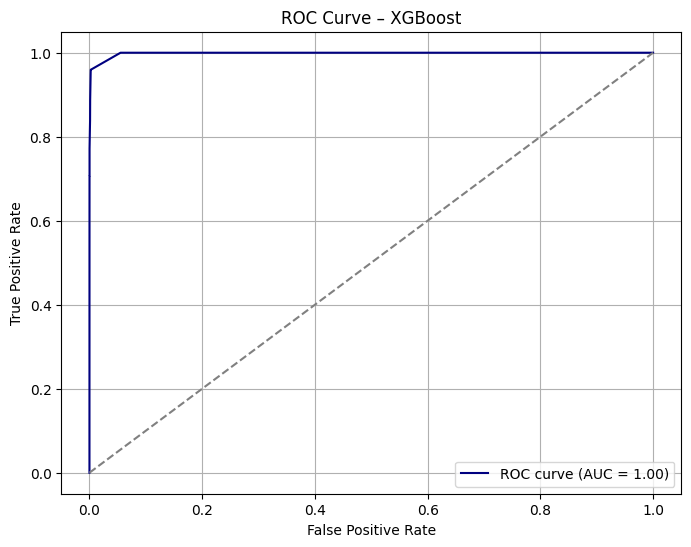

In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Example for XGBoost (replace as needed)
model = models["XGBoost"]
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color='navy')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – XGBoost')
plt.legend(loc="lower right")
plt.grid()
plt.show()


### Cross-Validation

In [48]:
from sklearn.model_selection import cross_val_score

# Example for Logistic Regression
model = LogisticRegression(max_iter=1000)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')

print("Cross-validated F1-scores:", cv_scores)
print("Mean F1:", cv_scores.mean())


Cross-validated F1-scores: [0.88874172 0.87533512 0.92991239 0.87752355 0.87449933]
Mean F1: 0.8892024237183914


### GridSearchCV for Hyperparameter Tuning

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)


Best Params: {'max_depth': 5, 'n_estimators': 100}
Best Score: 0.9511227482365907


## Notebook Markdown Cleanup
### Step 1: Data Preparation
Selected only numeric, model-ready columns.

---

### Step 2: Model Training
Trained 3 models: Logistic Regression, Random Forest, XGBoost.

---

### Step 3: Evaluation
Compared all models using F1, Precision, Recall, Confusion Matrix.

---

### Step 4: Model Selection and Saving
Chose XGBoost as the best performer. Saved it using `joblib`.

---

### Step 5: ROC Curve & Cross-Validation
Added robustness evaluation with AUC and CV scoring.
